## Ingest_clearing_spreadsheets
The idea here is to use the google sheets API to ingest the information stored in the core facility clearing google sheets into the braincogs00 database. We will be making a new database table for each clearing protocol spreadsheet. These will be linked to the Experiments() table in the database by the experiment_id primary key.

In [3]:
import pickle
import os.path
from datetime import datetime
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pandas as pd
import datajoint as dj

## Google Spreadsheet API setup

We will be using the Google Sheets API: https://developers.google.com/sheets/api/quickstart/python

For details on how to set this up on your machine, see this notebook: [Microscope_management.ipynb](Microscope_management.ipynb).

In [5]:
# Set the scope to be read only since we are not adding anything to the google sheet, just reading it
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# Set the spreadsheet ID (long string in the url, e.g.: 
# https://docs.google.com/spreadsheets/d/1YbP64yIApUaxjpscBXP8r82VmrkrKYakbjRFqF9XHB0/edit#gid=0) 
# As well as the range of cells you want to grab. 
SPREADSHEET_ID = '1iy4H8kHocnu9sS9P-NZA8qcp6_R4gj0ogwksl3I-suU'
range_query = 'iDISCO+!A3:BF13' # Syntax is Sheet_name!cell_start:cell_end, e.g. 
# Sheet1!A1:C will grab all data in columns A-C up until the last row of column C
secrets_file = 'credentials.json' # Has to be called "credentials.json"  
assert os.path.exists(secrets_file)

In [6]:
def retrieve_google_sheet():
    """
    ---PURPOSE---
    Gets the data from the range of cells in the google sheet specified.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                secrets_file, SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                range=range_query).execute()
    values = result.get('values', [])

    return values

In [8]:
values = retrieve_google_sheet()
values

[['Name',
  'Sample Name/#',
  'Experimental Objectives. Required, provided by experimenter. This hopefully will prevent miscommunications. Description of experiment - fluorophores/dyes involved. Antibody and concentrations desired. Type of analysis to be done. Purpose of clearing',
  'Experimental Notes: If anything unusual happened during the experiment that might affect clearing, please note it here.',
  'Primary antibody+conc',
  'Secondary antibody+conc',
  'Perfusion',
  '1xPBS 30 min R@RT',
  '2xPBS 30 min R@RT',
  '3xPBS 30 min R@RT',
  '20% CH3OH R@RTx1hr',
  '40% CH3OH R@RTx1hr',
  '60% CH3OH R@RTx1hr',
  '80% CH3OH R@RTx1hr',
  '100% CH3OH R@RTx1hr',
  '100% CH3OH R@RTX1hr',
  '5% H2O2(30%) in CH3OH(100%) O/N R@RT (1 part H2O2:5 parts methanol)',
  '100% CH3OH R@RTx1hr',
  '80% CH3OH R@RTx1hr',
  '60% CH3OH R@RTx1hr',
  '40% CH3OH R@RTx1hr',
  '20% CH3OH R@RTx1hr',
  'PBS R@RTx1hr',
  '0.2%TritonX-100/1xPBS/0.1% sodium azide R@RTx1hr',
  '0.2%TritonX-100/1xPBS/0.1% sodium az

In [9]:
values[0]

['Name',
 'Sample Name/#',
 'Experimental Objectives. Required, provided by experimenter. This hopefully will prevent miscommunications. Description of experiment - fluorophores/dyes involved. Antibody and concentrations desired. Type of analysis to be done. Purpose of clearing',
 'Experimental Notes: If anything unusual happened during the experiment that might affect clearing, please note it here.',
 'Primary antibody+conc',
 'Secondary antibody+conc',
 'Perfusion',
 '1xPBS 30 min R@RT',
 '2xPBS 30 min R@RT',
 '3xPBS 30 min R@RT',
 '20% CH3OH R@RTx1hr',
 '40% CH3OH R@RTx1hr',
 '60% CH3OH R@RTx1hr',
 '80% CH3OH R@RTx1hr',
 '100% CH3OH R@RTx1hr',
 '100% CH3OH R@RTX1hr',
 '5% H2O2(30%) in CH3OH(100%) O/N R@RT (1 part H2O2:5 parts methanol)',
 '100% CH3OH R@RTx1hr',
 '80% CH3OH R@RTx1hr',
 '60% CH3OH R@RTx1hr',
 '40% CH3OH R@RTx1hr',
 '20% CH3OH R@RTx1hr',
 'PBS R@RTx1hr',
 '0.2%TritonX-100/1xPBS/0.1% sodium azide R@RTx1hr',
 '0.2%TritonX-100/1xPBS/0.1% sodium azide R@RTx1hr',
 '20%DMSO/

We get a list of lists back where each sublist is a row in the Google sheet. The first row is the column headers, so those will be important when making our datajoint table. This list of lists format is actually convenient for inserting into the database as we will see shortly.

## Defining the database table
Since we are going to be adding a table to an existing database in datajoint, we will first need to connect to the database

In [25]:
# Need to port forward 3306 from jtb3-dev@pni.princeton.edu first (set this up externally on the machine)
db = dj.create_virtual_module(module_name='lightsheet',schema_name='ahoag_lightsheet_demo',create_schema=False,
                                 create_tables=True)

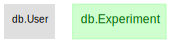

In [26]:
# Show the current structure of the database via the "Entity Relationship Diagram (ERD)"
dj.ERD(db)

In [18]:
# Now let's add a new table for the iDISCO+ clearing if it does not already exist
if "IdiscoPlusClearing" in dir(db):
    IdiscoPlusClearing = db.IdiscoPlusClearing
else:
    @db.schema #  
    class IdiscoPlusClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Periodic calibration data of the light sheet microscope
        -> db.Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> db.User                    # username, the researcher's netid from the User() table
        clearer                       :   varchar(20)   # the netid of the person who did the clearing
        exp_notes                     :   varchar(200)  # Note anything unusual that happened to subject that could affect clearing
        perfusion_date                :   varchar(10) 
        time_1xPBS_dehydr                :   datetime
        time_2xPBS_dehydr               :   datetime
        time_3xPBS_dehydr                    :   datetime
        time_20percent_CH3OH_dehydr          :   datetime
        time_40percent_CH3OH_dehydr          :   datetime
        time_60percent_CH3OH_dehydr          :   datetime
        time_80percent_CH3OH_dehydr          :   datetime
        time_100percent_CH3OH_dehydr         :   datetime
        time_5percent_H2O2_in_CH3OH          :   datetime
        time_20percent_CH3OH_rehydr          :   datetime
        time_40percent_CH3OH_rehydr          :   datetime
        time_60percent_CH3OH_rehydr          :   datetime
        time_80percent_CH3OH_rehydr          :   datetime
        time_100percent_CH3OH_rehydr         :   datetime
        time_sodium_azide_hour1              :   datetime
        time_sodium_azide_hour2              :   datetime
        
        """

In [24]:
db.Microscope()

DataJointError: The table `ahoag_lightsheet_demo`.`microscope` is not defined.

DataJointError: The table `ahoag_lightsheet_demo`.`microscope` is not defined.

In [22]:
IdiscoPlusClearing()

experiment_id allowed here are sql datatypes.,username user in the lab,notes
1,ahoag,some notes


## Entering the google sheets data into the database 

In [70]:
# Only does this if the table does not already exist.
if len(Microscope.fetch()) == 0:
    values = retrieve_google_sheet()
    column_names = ['username','date','old_objective','new_objective','swapper','calibration','notes'] # in the database
    for row in values[1:]: # skip the first row because it is the column names
        if len(row) < 2:
            continue
        try:
            date_str = datetime.strptime(row[0], "%B %d, %Y").strftime("%Y-%m-%d")
        except:
            date_str = 'unknown'
        for ii in range(len(column_names)-len(row)):
            row.append('')
        insert_row = ['ahoag',date_str] + row[1:]    
        insert_dict = {column_names[ii]:insert_row[ii] for ii in range(len(column_names))}
        Microscope().insert1(insert_dict,skip_duplicates = True)

In [71]:
df = pd.DataFrame(Microscope.fetch())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,entrynum,username,date,old_objective,new_objective,swapper,calibration,notes
0,1,ahoag,2018-02-20,1.3x,4x,"Tom Pisano, Ben Deverett, Stephan Thiberge",,
1,2,ahoag,2018-03-09,4x,1.3x,"Tom Pisano, Kelly Seagraves",,
2,3,ahoag,2018-03-13,1.3x,4x,"Tom Pisano, Kelly Seagraves",,
3,4,ahoag,2018-03-20,4x,4x,"Tom Pisano, Kelly Seagraves",Calibration: Bilateral individual sheets relat...,
4,5,ahoag,2018-03-29,4x,4x,"Tom Pisano, Stephan",Calibration: Bilateral individual sheets relat...,
5,6,ahoag,2018-04-11,4x,4x,Tom Pisano,Calibration: Bilateral individual sheets relat...,Within sheets OK. Left drifted relative to R
6,7,ahoag,2018-04-23,4x,4x,Tom Pisano,Calibration: Bilateral individual sheets relat...,Left sheet downward beam seems slightly off. P...
7,8,ahoag,2018-04-30,4x,1.3x,Tom Pisano,Calibration: Bilateral individual sheets relat...,Left sheet downward beam seems slightly off. P...
8,9,ahoag,2018-05-07,1.3x,4x,Tom Pisano,Calibration: Bilateral individual sheets relat...,Fairly OK except for R upward pointing sheet. ...
9,10,ahoag,2018-07-10,1.3x,4x,"Tom, Zahra","Calibration, Left relative to right. Seems tha...",


## Querying the database

In [72]:
# Select all entries where Zahra is the sole swapper
Microscope() & 'swapper = "Zahra" '

entrynum allowed here are sql datatypes.,username who entered the data into the database,date,old_objective,new_objective,swapper,calibration,notes
14,ahoag,2018-10-15,4x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,Ok because sheets were aligned last week; only sheetmotor move on left was needed
15,ahoag,2018-10-22,4x,4x,Zahra,Calibration check,No sheetomotor or alignment needed
16,ahoag,2018-11-12,4x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,Slight sheetmotor move on L and mirror central mirror adjustment. No need to adjust up/down L mirrors.
17,ahoag,2018-11-21,4x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,Alignment after restoring old LS computer. Slight sheetmotor move on L and mirror central mirror adjustment. No need to adjust up/down L mirrors.
18,ahoag,2018-12-07,4x,4x,Zahra,Calibration check,No sheetomotor or alignment needed :D
19,ahoag,2018-12-18,4x,4x,Zahra,Calibration check,No sheetomotor or alignment needed :D
20,ahoag,2018-12-21,4x,1.3x,Zahra,Calibration: Bilateral individual sheets relative to each other,Left central mirror adjustment and slight left sheetmotor move.
21,ahoag,2019-01-03,1.3x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Slight right and left sheetmotor move, no mirror adjustment needed!"
22,ahoag,2019-01-11,4x,1.3x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Slight right and left sheetmotor move, no mirror adjustment needed."
23,ahoag,2019-01-27,1.3x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,Left central mirror adjustment and left and right sheetmotor move.


In [73]:
# Make the same query, but print only the date 
query = Microscope() & 'swapper = "Zahra"'
query.fetch('date')

array(['2018-10-15', '2018-10-22', '2018-11-12', '2018-11-21',
       '2018-12-07', '2018-12-18', '2018-12-21', '2019-01-03',
       '2019-01-11', '2019-01-27', '2019-02-06', '2019-02-09',
       '2019-03-05', '2019-03-08', '2019-03-11', '2019-03-22',
       '2019-05-21', '2019-06-03', '2019-06-13', '2019-06-19',
       '2019-07-19', '2019-08-05', '2019-08-20', '2019-08-27',
       '2019-09-12'], dtype=object)

In [74]:
# Query by date range
Microscope() & 'date > "2019-01-01"' & 'date < "2019-05-01"'

entrynum allowed here are sql datatypes.,username who entered the data into the database,date,old_objective,new_objective,swapper,calibration,notes
21,ahoag,2019-01-03,1.3x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Slight right and left sheetmotor move, no mirror adjustment needed!"
22,ahoag,2019-01-11,4x,1.3x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Slight right and left sheetmotor move, no mirror adjustment needed."
23,ahoag,2019-01-27,1.3x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,Left central mirror adjustment and left and right sheetmotor move.
24,ahoag,2019-02-06,4x,4x,Zahra,Calibration check,"Very very slight sheetmotor shift for left ls, but probably not necessary!"
25,ahoag,2019-02-09,4x,1.3x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Slight sheetmotor move in left and right, trying to align zoom body to center of cuvette holder"
27,ahoag,2019-03-05,4x,4x,Zahra,Calibration check,No sheetomotor or alignment needed :D
28,ahoag,2019-03-08,4x,1.3x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Slight right and left sheetmotor move, no mirror adjustment needed!"
29,ahoag,2019-03-11,1.3x,4x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Aligned to ""center"" (aka center of cuvette); horizontal foci seem to be centered; moved zoom body into center position while keeping calibration tool and laser on"
30,ahoag,2019-03-22,4x,1.3x,Zahra,Calibration: Bilateral individual sheets relative to each other,"Aligned to ""center"" (aka center of cuvette); horizontal foci seem to be centered; moved zoom body into center position while keeping calibration tool and laser on; Slightly shifted left sheetmotor calibration"
31,ahoag,2019-04-08,1.3x,4x,"Zahra, John",Calibration: Bilateral individual sheets relative to each other,"Aligned to ""center"" (aka center of cuvette); horizontal foci seem to be centered; moved zoom body into center position while keeping calibration tool and laser on"


For more information on queries and filtering, see the Datajoint python docs: https://docs.datajoint.io/python/queries/Queries.html

## Inserting new rows via datajoint

In [76]:
# Example: one row at a time 
column_names = ['date','username','old_objective','new_objective','swapper','calibration','notes'] # in the database
row = ['2019-09-13','ahoag','4x','1x','Austin','some calibration','some notes']
# Insert via a dictionary
insert_dict = {column_names[ii]:row[ii] for ii in range(len(column_names))}
print(insert_dict)
# Uncomment the line below to actually insert the data. I commented it by default as to not perturb the table
#Microscope().insert1(insert_dict,skip_duplicates = True)

{'date': '2019-09-13', 'username': 'ahoag', 'old_objective': '4x', 'new_objective': '1x', 'swapper': 'Austin', 'calibration': 'some calibration', 'notes': 'some notes'}


In [ ]:
# Now check that it was added to the table:
Microscope() # simply lists the contents (abbreviates if they are long)

In [77]:
# If you cannot see the last entries to see if your new row was inserted,
# one option is to use a pandas dataframe, then just look at the last few entries
df = pd.DataFrame(Microscope.fetch())
df[-5:]

,entrynum,username,date,old_objective,new_objective,swapper,calibration,notes
40,41,ahoag,2019-08-05,4x,1.3x (air objective),Zahra,Calibration: Bilateral individual sheets relat...,"Aligned to ""center"" (aka center of cuvette); m..."
41,42,ahoag,2019-08-20,1.3x (air objective),1.3x (dipping cap),Zahra,Calibration check,"Just moved body up for WD of dipping cap, no o..."
42,43,ahoag,2019-08-27,1.3x (dipping cap),1.3x (air objective),Zahra,Calibration check,"Moved zoom body down to alignment tool, re-cen..."
43,44,ahoag,2019-09-05,1.3x (air objective),4x,"Zahra, John",Calibration: Bilateral individual sheets relat...,Moved zoom body down to bottom of pillar; alig...
44,45,ahoag,2019-09-12,4x,1.3x (air objective),Zahra,Calibration: Bilateral individual sheets relat...,Moved zoom body up to alignment tool; aligned ...


So we can see that the data were inserted (if you uncommented the line above). 

## Removing data from the database

In [12]:
# To delete, simply wrap a query in parentheses whose row results are the ones you want to delete
# and use the delete() method

(Microscope() & 'swapper="Austin"').delete()

About to delete:
`ahoag_lightsheet_demo`.`microscope`: 1 items
Proceed? [yes, No]: No
Cancelled deletes.


In [16]:
# Using delete_quick() will override the interactive double-check
(Microscope() & 'swapper="Austin"').delete_quick()